In [108]:
import json
import pandas as pd
from transformers import pipeline
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

In [13]:
data = json.load(open('data/example_data.json'))

In [28]:
pipe = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [66]:
pipe_sum = pipeline("summarization", model="sshleifer/distilbart-cnn-6-6")

Error while downloading from https://cdn-lfs.hf.co/sshleifer/distilbart-cnn-6-6/68f994703e838fff13b9e54ab72d5ae44f184cb55300a7f65f46a7d282e8da23?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1731439452&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTQzOTQ1Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9zc2hsZWlmZXIvZGlzdGlsYmFydC1jbm4tNi02LzY4Zjk5NDcwM2U4MzhmZmYxM2I5ZTU0YWI3MmQ1YWU0NGYxODRjYjU1MzAwYTdmNjVmNDZhN2QyODJlOGRhMjM%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=MgriNufzU%7EVINKvHUaTmTwQDz80voHXdMtc7RY4aLs8eg0wWLztFiYIXrWVgyJ3LRDeX7FWjO9bVurKHAuFaqZl6Ukb3E9cEGA67T5H8UnO3DqlGya3gRwMU5eSSrpPRBfiVOSs9hvQ6m3Xv6pHm5-VxW5HzonayaVZoVvi-qc2DWyWtiQIIgZvea2L1Yois45Oon3TvbxJbB2ZuH6LCmwgpeFgfs7mosriMoHuksvrPm8l73bNE%7E1JlOKvaGpV6IgQgohAPC2ztvZI1esEIdVLDqwK8EPuZntqGU8

In [99]:
res = []
for k in tqdm(data.keys()):    
    posts_li = data[k]['posts']
    subreddit, subtopic = k.split('+')
    for i in range(len(posts_li)):
        # print(posts_li[i]['title'])
        comments_li = posts_li[i]['comments']
        for j in range(len(comments_li)):
            # print(comments_li[j]['body'])
            content = comments_li[j]['content']
            word_count = len(content.split())
            user_name = comments_li[j]['user_name']

            if word_count > 80:
                # if the conent is too long, we summarize it in order to fit the model
                content2 = pipe_sum("In 50 words, Can you summarize the following text\n " + content)[0]['summary_text']
                
                # print(content2)
            else:
                content2 = content
            
            try:
                sa = pipe(content2)[0]
            except:
                continue
            # print(sa)
            # {'label': 'POS', 'score': 0.9905712604522705}
            label = sa['label']
            score = sa['score']
            res.append([subreddit, subtopic, user_name, content2, label, score, content])
            pass

  0%|          | 0/24 [00:00<?, ?it/s]Your max_length is set to 142, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)
Your max_length is set to 142, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 142, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)
Your max_length is set to 142, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, 

In [101]:
df = pd.DataFrame(res, columns=['subreddit', 'subtopic', 'user_name', 'content2', 'label', 'score', 'content'])

## Plot for sentiment analysis distribution

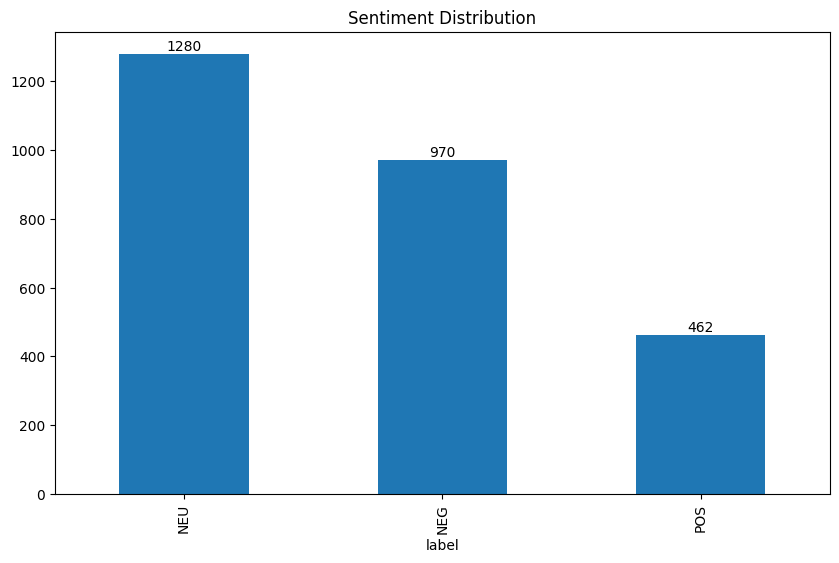

In [112]:
df['label'].value_counts()
# use matplotlib to plot the sentiment distribution with numbers on each bar
plt.figure(figsize=(10,6))
df['label'].value_counts().plot(kind='bar')
for i, v in enumerate(df['label'].value_counts()):
    plt.text(i, v + 10, str(v), ha='center')

plt.title('Sentiment Distribution')
plt.show()




By analyzing the scraped data from different subreddit, it seems that most of the people shows an attitude of neural and negative towards clinical trials. Only around 17% of people shows a positive attitude.

#### Further I would like to see the probability distribution under each catogory

<Figure size 1000x600 with 0 Axes>

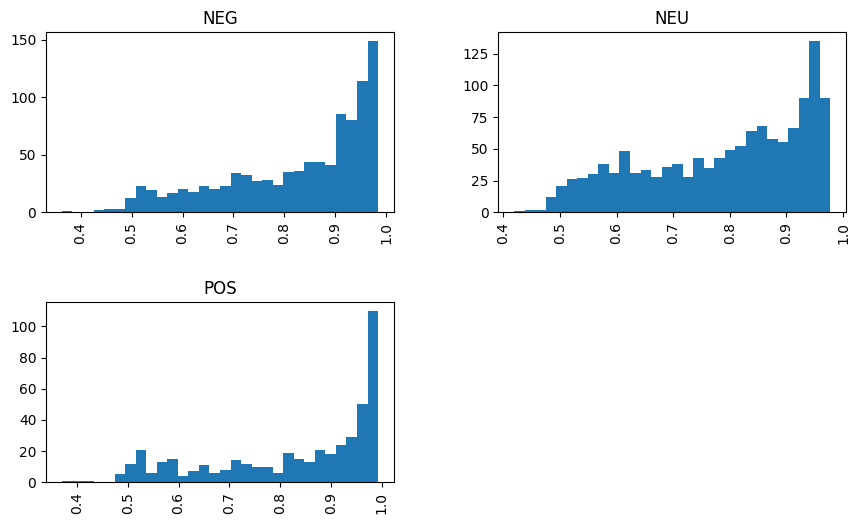

In [116]:
#Distribution of scores under each label

plt.figure(figsize=(10,6))
df['score'].hist(by=df['label'], bins=30, figsize=(10,6))
plt.show()


Overall, the model tends to assign a high probablity for each input text, showing left skewed distributions.

In [118]:
# give levels to the sentiment, this is threhold-based.
def catogorize_level(x):
    label = x['label']
    score = x['score']
    if label == 'POS' and score > 0.8:
        return 'strongly positive'
    elif label == 'POS' and score < 0.8 and score > 0.6:
        return 'positive'
    elif label == 'POS' and score < 0.6:
        return 'moderately positive'
    elif label == 'NEG' and score > 0.8:
        return 'strongly negative'
    elif label == 'NEG' and score < 0.8 and score > 0.6:
        return 'negative'
    elif label == 'NEG' and score < 0.6:
        return 'moderately negative'
    elif label == 'NEU' and score > 0.6:
        return 'neutral'
    elif label == 'NEU' and score < 0.6:
        return 'moderately neutral'

df['level'] = df.apply(catogorize_level, axis=1)

In [120]:
df.to_csv('data/raw_data_sentiment_analysis.csv', index=False)